In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from arch import arch_model
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.append(str(project_root))
from ingest.base import sqlite_connection

In [ ]:
with sqlite_connection() as conn:
    df = pd.read_sql("SELECT * FROM ohlcv", conn)

df = df[df["ticker"] == "BBVA.MC"]
df = df.reset_index(drop=True)
df["date"] = pd.to_datetime(df["date"])
df = df.set_index("date")
df = df.asfreq("B")
df["close"] = df["close"].ffill()
df.head(1)
prices = df["close"]
log_returns = np.log(prices).diff().dropna()

This is the continuation of arima/log-returns. Previously, we assumed constant variance, which is unrealistic. Using a GARCH model allows us to capture time-varying volatility and obtain more reliable forecasts and uncertainty estimates.

In [78]:
p,d,q = 0,0,0
model = ARIMA(log_returns, order=(p,d,q))
model_fit = model.fit()

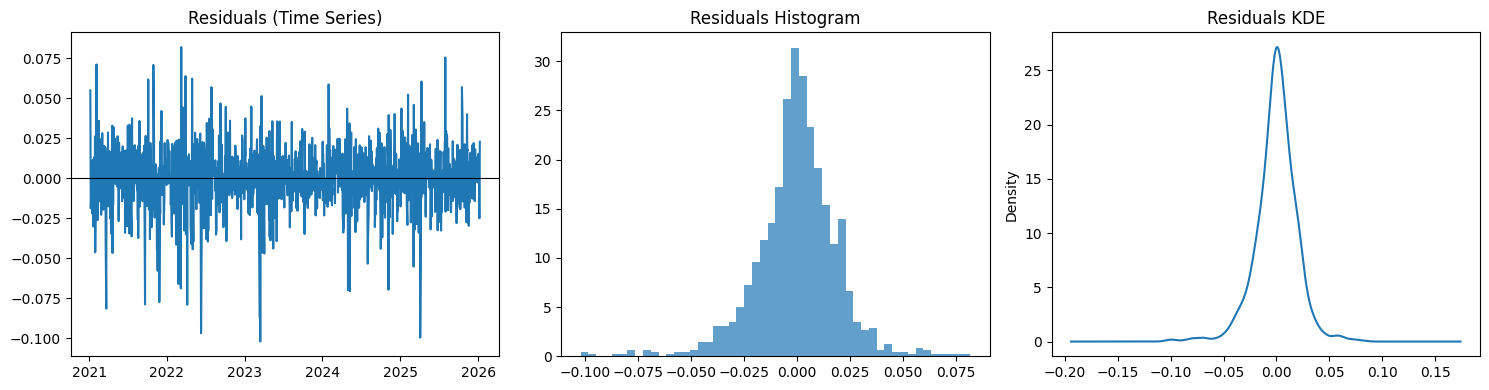

In [79]:
residuals = model_fit.resid

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].plot(residuals)
axes[0].set_title("Residuals (Time Series)")
axes[0].axhline(0, color="black", linewidth=0.8)

axes[1].hist(residuals, bins=50, density=True, alpha=0.7)
axes[1].set_title("Residuals Histogram")

residuals.plot(kind="kde", ax=axes[2])
axes[2].set_title("Residuals KDE")

plt.tight_layout()
plt.show()


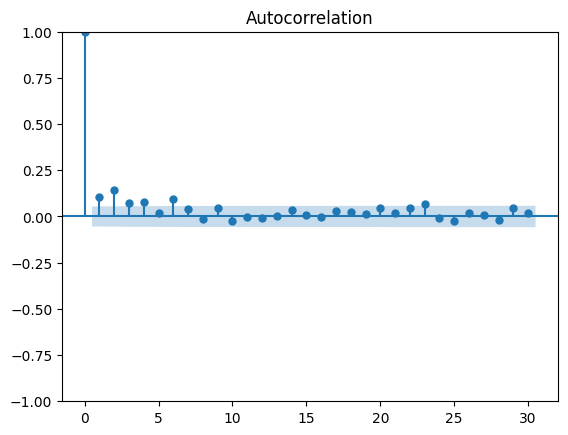

In [98]:
plot_acf(residuals**2, lags=30);

There is significant autocorrelation in squared residuals, indicating volatibility clustering.

In [81]:
arch_test = het_arch(residuals)
arch_test


(np.float64(58.977913362289875),
 np.float64(5.6544229891296016e-09),
 6.1261679929569715,
 3.5718425494600313e-09)

The Autoregressive Conditional Heteroskedasticity (ARCH) test confirms that there is heteroskedasticity. We will use GARCH(1,1) to capture time-varying volatibility. 

In [82]:
scaled_returns = log_returns*100
garch = arch_model(
    scaled_returns,
    mean='Constant',   # only GARCH
    vol='GARCH',
    p=1,
    q=1,
    dist='skewt'       # normal / t / skewt
)

garch_fit = garch.fit(update_freq=5)
print(garch_fit.summary())


Iteration:      5,   Func. Count:     44,   Neg. LLF: 3607.831555965945
Iteration:     10,   Func. Count:     85,   Neg. LLF: 2606.57196516538
Iteration:     15,   Func. Count:    120,   Neg. LLF: 2606.5567027147854
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2606.5567027147854
            Iterations: 15
            Function evaluations: 120
            Gradient evaluations: 15
                           Constant Mean - GARCH Model Results                           
Dep. Variable:                             close   R-squared:                       0.000
Mean Model:                        Constant Mean   Adj. R-squared:                  0.000
Vol Model:                                 GARCH   Log-Likelihood:               -2606.56
Distribution:      Standardized Skew Student's t   AIC:                           5225.11
Method:                       Maximum Likelihood   BIC:                           5256.17
                                 

We have chosen to model GARCH with error distribution skew-t, as returns have fat tails and are asymmetric.


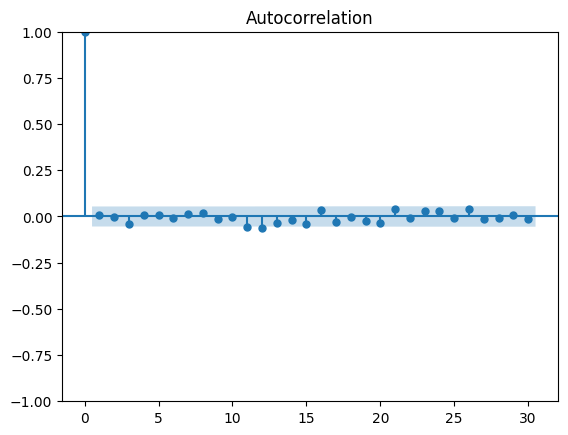

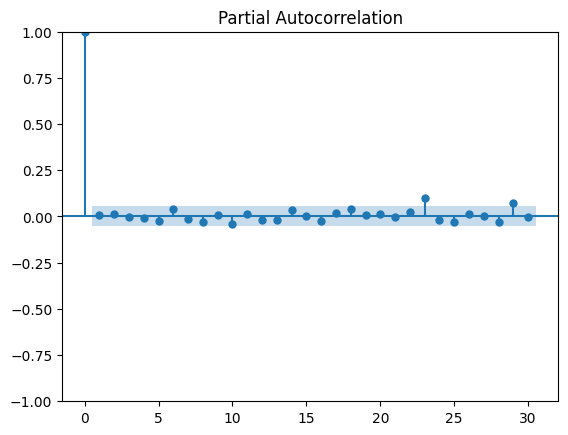

In [83]:
std_resid = garch_fit.std_resid
plot_acf(std_resid, lags=30);
plot_pacf(std_resid**2, lags=30);



In [84]:
arch_test = het_arch(std_resid)
arch_test



(np.float64(7.112332678177774),
 np.float64(0.7147992156836663),
 0.7090913011668598,
 0.7165988660022171)

After modeling the variance with GARCH, the ARCH effects are successfully removed.

In [85]:
forecast = garch_fit.forecast(horizon=10)

variance_forecast = forecast.variance.iloc[-1]
volatility_forecast = np.sqrt(variance_forecast)/100


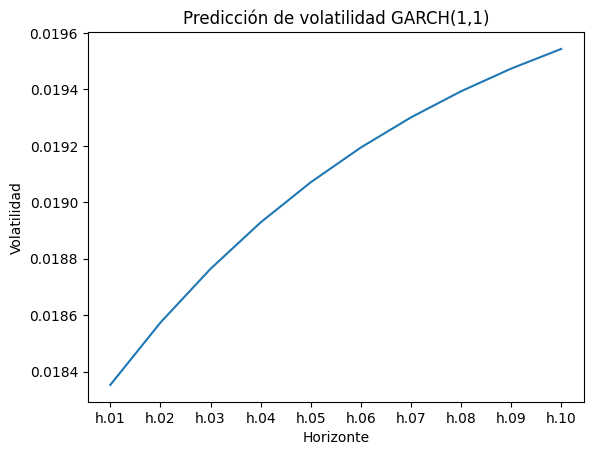

In [86]:
plt.plot(volatility_forecast)
plt.title("Predicción de volatilidad GARCH(1,1)")
plt.ylabel("Volatilidad")
plt.xlabel("Horizonte")
plt.show()

In [87]:
train_size = int(len(log_returns)-7) 
train = log_returns.iloc[:train_size] 
test = log_returns.iloc[train_size:] 
p,d,q = 0,0,0 
op_model = ARIMA(train, order=(p,d,q)) 
op_model_fit = op_model.fit() 
forecast = op_model_fit.forecast(steps=len(test)) 
last_train_price = prices.iloc[train_size-1] 
price_forecast = last_train_price * np.exp(forecast.cumsum()) 
test_prices = prices.iloc[train_size:] 
train_prices = prices.iloc[:train_size] 

In [88]:
train_scaled = train * 100
garch = arch_model(
    train_scaled,
    mean='Zero',        # ARIMA -> GARCH
    vol='GARCH',
    p=1,
    q=1,
    dist='skewt'
)

garch_fit = garch.fit(disp="off")

In [89]:
garch_forecast = garch_fit.forecast(horizon=len(test))

variance_fc = garch_forecast.variance.iloc[-1]
sigma_fc = np.sqrt(variance_fc)/100

z = 1.96  # 95%
ret_mean = forecast
ret_upper = forecast + z * sigma_fc.values
ret_lower = forecast - z * sigma_fc.values


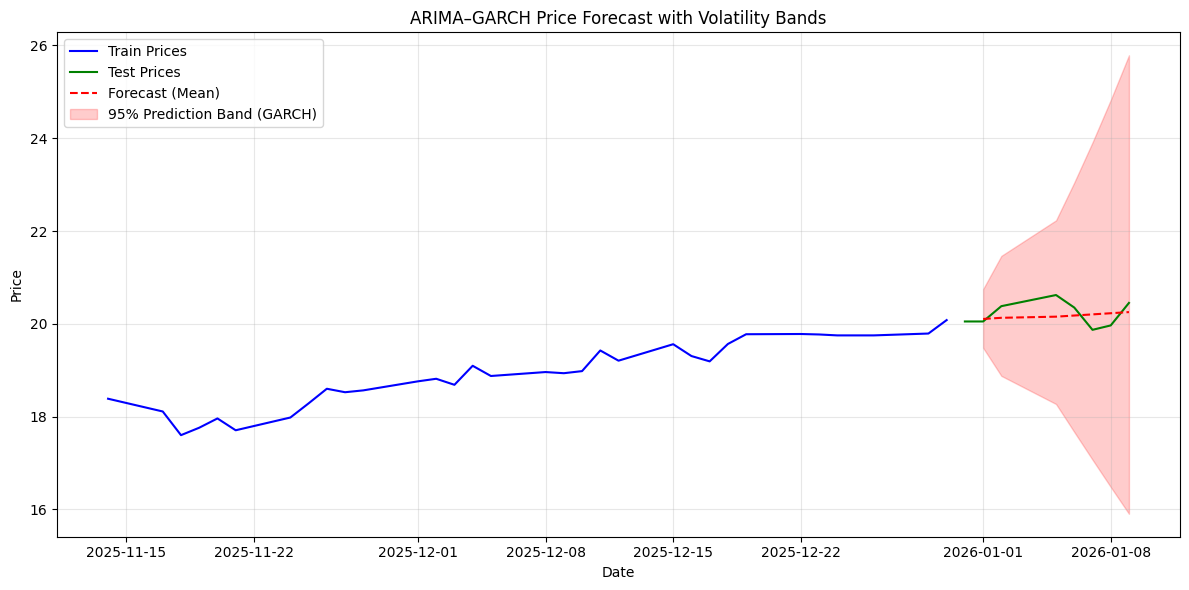

In [90]:
last_train_price = prices.iloc[train_size - 1]

price_forecast = last_train_price * np.exp(ret_mean.cumsum())
price_upper = last_train_price * np.exp(ret_upper.cumsum())
price_lower = last_train_price * np.exp(ret_lower.cumsum())

zoom_window = 33
plot_start = train_size - zoom_window
zoom_train_prices = prices.iloc[plot_start:train_size] 
zoom_test_prices = prices.iloc[train_size:]

plt.figure(figsize=(12, 6))

plt.plot(
    zoom_train_prices.index,
    zoom_train_prices,
    label="Train Prices",
    color="blue"
)

plt.plot(
    zoom_test_prices.index,
    zoom_test_prices,
    label="Test Prices",
    color="green"
)

plt.plot(
    price_forecast.index,
    price_forecast,
    label="Forecast (Mean)",
    color="red",
    linestyle="--"
)

plt.fill_between(
    price_forecast.index,
    price_lower,
    price_upper,
    color="red",
    alpha=0.2,
    label="95% Prediction Band (GARCH)"
)

plt.title("ARIMA–GARCH Price Forecast with Volatility Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We construct confidence bands around the price forecast to quantify forecast uncertainty and market risk.

In [91]:
rmse_price = np.sqrt(mean_squared_error(test_prices.iloc[1:], price_forecast))
print(f"RMSE (Price): {rmse_price:.4f} €")

rmse_return = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE (Log Returns): {rmse_return:.6f}")

RMSE (Price): 0.2756 €
RMSE (Log Returns): 0.015621
